### TOXIC COMMENT CLASSIFICATION

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import hamming_loss,accuracy_score,log_loss


In [81]:
## Import necessary files
df = pd.read_csv('./data/jigsaw-toxic-comment-classification-challenge/train.csv')
df =df.iloc[:30000,:]
print(df.shape)

(30000, 8)


In [82]:
#List the fields in our dataframe
print(df.dtypes)

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object


Hence we have a sufficiently large dataset consistly of 95851 samples. Each sample contains 8 fields.
#### It was observed that running train_test_split on the heavy preprocessed dataframe sometimes resulted in system going out of memory. Hence to avoid such cases, one extra line of code was added. The df.reindex code will shuffle the indices initially, so that later splitting dataset into training and testing will give fairer results.

In [83]:
# below line causes shuffling of indices, to avoid using train_test_split later
df = df.reindex(np.random.permutation(df.index))
#rearranging datafram columns indexes based param , it can be df.max/min whatevr order here we are doing randomly

#### Separate the comment field data and outcome labels

In [84]:
comment = df['comment_text']
print(comment.head())
comment = comment.as_matrix()

17025    Hi, likewise. We need as many South Africans a...
9334                Replied on your talk page.  (chew)(do)
7385     And OH NO! Look who showed up. Is it the MILLI...
6558     as an umbrella article for these plus treehous...
21491    Well played the other day. Yeah, that Alphachi...
Name: comment_text, dtype: object


/Users/utkarsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [85]:
label = df[['toxic', 'severe_toxic' , 'obscene' , 'threat' , 'insult' , 'identity_hate']]
print(label.head())
label = label.as_matrix()

       toxic  severe_toxic  obscene  threat  insult  identity_hate
17025      0             0        0       0       0              0
9334       0             0        0       0       0              0
7385       0             0        0       0       0              0
6558       0             0        0       0       0              0
21491      0             0        0       0       0              0


/Users/utkarsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


#### frequency of occurence of multilabelled data
ct1 counts samples having atleast one label
ct2 counts samples having 2 or more than 2 labels

In [86]:
ct1,ct2 = 0,0
for i in range(label.shape[0]):
    ct = np.count_nonzero(label[i])
    if ct :
        ct1 = ct1+1
    if ct>1 :
        ct2 = ct2+1
print(ct1)
print(ct2)

3127
1877


### Data Visualisations

no. of comments having lengths varying from 0 to 1200

average length of comment: 393.184


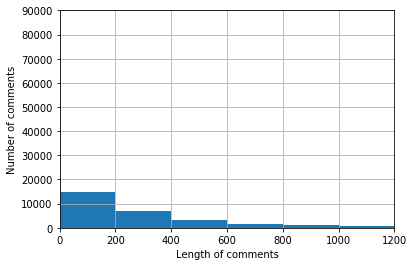

In [87]:
x = [len(comment[i]) for i in range(comment.shape[0])]

print('average length of comment: {:.3f}'.format(sum(x)/len(x)) )
bins = [1,200,400,600,800,1000,1200]
plt.hist(x, bins=bins)
plt.xlabel('Length of comments')
plt.ylabel('Number of comments')       
plt.axis([0, 1200, 0, 90000])
plt.grid(True)
plt.show()


Number of comments classified as toxic,severe_toxic,....etc depending on their lengths

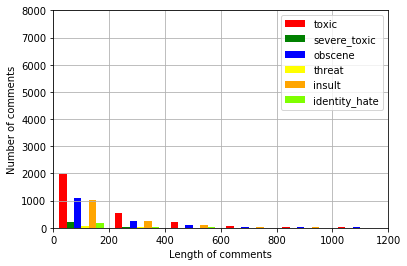

In [88]:
y = np.zeros(label.shape)
for ix in range(comment.shape[0]):
    l = len(comment[ix])
    if label[ix][0] :
        y[ix][0] = l
    if label[ix][1] :
        y[ix][1] = l
    if label[ix][2] :
        y[ix][2] = l
    if label[ix][3] :
        y[ix][3] = l
    if label[ix][4] :
        y[ix][4] = l
    if label[ix][5] :
        y[ix][5] = l

labelsplt = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
color = ['red','green','blue','yellow','orange','chartreuse']        
plt.hist(y,bins = bins,label = labelsplt,color = color)
plt.axis([0, 1200, 0, 8000])
plt.xlabel('Length of comments')
plt.ylabel('Number of comments') 
plt.legend()
plt.grid(True)
plt.show()

#### Remove excessive length comments
Some very large length comments can be seen, in our dataset. These pose serious problems like adding excessively more words to the training dataset, causing training time to increase and accuracy to decrease!
Hence, a threshold of 400 characters will be created and only comments which have length smaller than 400 will be used further

In [89]:

comments = []
labels = []

for ix in range(comment.shape[0]):
    if len(comment[ix])<=400:
        comments.append(comment[ix])
        labels.append(label[ix])

In [90]:
labels = np.asarray(labels)

In [91]:
print(len(comments))

21797


### Preprocessing
#### Preprocessing involved the following steps, but these will be performed in a slightly different manner:

- Removing Punctuations and other special characters
- Splitting the comments into individual words
- Removing Stop Words 
- Stemming and Lemmatising
- Applying Count Vectoriser
- Splitting dataset into Training and Testing

The string library contains punctuation characters. This is imported and all numbers are appended to this string. Also, we can notice that our comment_text field contains strings such as won't, didn't, etc which contain apostrophe character('). To prevent these words from being converted to wont/didnt, the character ' represented as \' in escape sequence notation is replaced by empty character in the punctuation string.

maketrans() returns a translation table that maps each character in the punctuation_edit into the character at the same position in the outtab string i.e. it replaces every character in the removal list with a space, since outtab contains a string with spaces.

In [92]:
import string
print(string.punctuation)
punctuation_edit = string.punctuation.replace('\'','') +"0123456789"
print (punctuation_edit)
outtab = "                                         "
trantab = str.maketrans(punctuation_edit, outtab)


!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
!"#$%&()*+,-./:;<=>?@[\]^_`{|}~0123456789


Stop words are those words that are frequently used in both written and verbal communication and thereby do not have either a positive/negative impact on our statement.E.g. is, this, us,etc.
Single letter words if existing or created due to any preprocessing step do not convey any useful meaning and hence can be directly removed. Hence letters from b to z, will be added to the list of stop words imported directly.

In [93]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.append('')

for x in range(ord('b'), ord('z')+1):
    stop_words.append(chr(x))

In [94]:
print (stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

- Stemming is the process of converting inflected/derived words to their word stem or the root form. Basically, a large number of similar origin words are converted to the same word.E.g. words like "stems", "stemmer", "stemming", "stemmed" as based on "stem". This helps in achieving the training process with a better accuracy.
- Lemmatizing is the process of grouping together the inflected forms of a word so they can be analysed as a single item. This is quite similar to stemming in its working but differs since it depends on correctly identifying the intended part of speech and meaning of a word in a sentence, as well as within the larger context surrounding that sentence, such as neighboring sentences or even an entire document.
The wordnet library in nltk will be used for this purpose. Stemmer and Lemmatizer are also imported from nltk.

In [95]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [96]:
#create objects for stemmer and lemmatizer
lemmatiser = WordNetLemmatizer()
stemmer = PorterStemmer()
#download words from wordnet library
#nltk.download('wordnet')

In [97]:
for i in range(len(comments)):
    comments[i] = comments[i].lower().translate(trantab)
    l = []
    for word in comments[i].split():
        l.append(stemmer.stem(lemmatiser.lemmatize(word,pos="v")))
    comments[i] = " ".join(l)

#### Applying Count Vectorize

In [98]:
#import required library
from sklearn.feature_extraction.text import CountVectorizer

#create object supplying our custom stop words
count_vector = CountVectorizer(stop_words=stop_words)
#fitting it to converts comments into bag of words format
tf = count_vector.fit_transform(comments).toarray()

In [99]:
# print(count_vector.get_feature_names())
print(tf.shape)

(21797, 26082)


### Splitting dataset into training and testing

- Since the system was going out of memory using train_test_split, I had jumbled all the indexes in the beginning itself.
- The shuffle function defined here performs the task of assigning first 2/3rd values to train and remaining 1/3rd values to the test set.

In [100]:
def shuffle(matrix, target, test_proportion):
    ratio = int(matrix.shape[0]/test_proportion)
    X_train = matrix[ratio:,:]
    X_test =  matrix[:ratio,:]
    Y_train = target[ratio:,:]
    Y_test =  target[:ratio,:]
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = shuffle(tf, labels,3)

print(X_test.shape)
print(X_train.shape)

(7265, 26082)
(14532, 26082)


### Implementation :

In [101]:
#all the evaluation metrics
def evaluate_score(Y_test,predict): 
    loss = hamming_loss(Y_test,predict)
    print("Hamming_loss : {}".format(loss*100))
    accuracy = accuracy_score(Y_test,predict)
    print("Accuracy : {}".format(accuracy*100))
    try : 
        loss = log_loss(Y_test,predict)
    except :
        loss = log_loss(Y_test,predict.toarray())
    print("Log_loss : {}".format(loss))

#### Problem Transformation Methods :
These include the Binary Relevance, Label Powerset and Classifier Chain methods. Implementations of these methods is available in the scikit-multilearn library.

- I will be implementing the most basic method,which is the Binary Relevance method from scratch. It does not take into account the interdependence of labels and basically creates a separate classifier for each of the labels.
- Scikit-multilearn library's classifier will also be imported and tested with different classifiers to observe if it gives similar results.

In [102]:
from sklearn.naive_bayes import MultinomialNB

In [103]:
# each classifier is fit with the training data and corresponding classifier
clf = []
for ix in range(6):
    clf.append(MultinomialNB())
    clf[ix].fit(X_train,Y_train[:,ix])

In [104]:

# predict list contains the predictions, it is transposed later to get the proper shape
predict = []
for ix in range(6):
    predict.append(clf[ix].predict(X_test))

predict = np.asarray(np.transpose(predict))
print(predict.shape)

(7265, 6)


In [105]:
# calculate results
evaluate_score(Y_test,predict)

Hamming_loss : 3.6361550814406973
Accuracy : 87.4741913282863
Log_loss : 2.1568864435763344


In [106]:
from sklearn.linear_model import LogisticRegression

In [108]:
# each classifier is fit with the training data and corresponding classifier
clf = []
for ix in range(6):
    clf.append(LogisticRegression())
    clf[ix].fit(X_train,Y_train[:,ix])
    
# predict list contains the predictions, it is transposed later to get the proper shape
predict = []
for ix in range(6):
    predict.append(clf[ix].predict(X_test))

predict = np.asarray(np.transpose(predict))
print(predict.shape)
# calculate results
evaluate_score(Y_test,predict)

(7265, 6)
Hamming_loss : 2.525808671713696
Accuracy : 89.40123881624226
Log_loss : 2.0082915685041653


- While showing among the best problem transformation method models, hamming-loss was considered 
- But while chosing among the best Adaptation Algorithm model, log loss was preferred.